In [1]:
####################################
## Batch lengths are being weird ###
####################################


import torch, pickle, time, os, random
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
# accelerate huggingface to GPU
if torch.cuda.is_available():
    from accelerate import Accelerator
    accelerator = Accelerator()
    device = accelerator.device

torch.manual_seed(42)
random.seed(42)

In [2]:
os.listdir('../../../../scratch/gpfs/cj1223/GraphStorage/')

['vlarge_all_multit_z0.0_standard_stand',
 'medium_beforeafter',
 'medium_redshift_50_all',
 'vlarge_all_multit_z0.5_power_quant',
 'vlarge_all_multit_z0.0_None',
 'vlarge_all_multit_z2.0_standard_quant',
 'medium_smass_z1.0_standard',
 'vlarge_all_multisimple_z0.0_quantile_quant',
 'test_onlyhmass_smass',
 'medium_redshift_80_all',
 'vlarge_all_final',
 'vlarge_all_multit_z1.0_standard_stand',
 'vlarge_all_multit_z1.0_power_quant',
 'medium_all_q_diffbeforeafter',
 'vlarge_redshift_85_all',
 'vlarge_all_multi_z0.5_quantile',
 'medium_all_smass',
 'medium_onlyhmass_smass',
 'vlarge_all_multi_z1.0_power',
 'vlarge_all_multit_z0.0_quantile_quant',
 'vlarge_all_multit_z0.0_standard_quant',
 'vlarge_all_multit_z0.5_quantile_quant',
 'vlarge_all_multit_z0.0_quantile_raw',
 'medium_scaleonly_smass',
 'vlarge_all_multi_z0.5_None',
 'vlarge_all_multit_z2.0_None',
 'vlarge_all_multit_z1.0_standard_quant',
 'vlarge_all_multit_z0.0_power_quant',
 'vlarge_all_multi_z0.5_standard',
 'vlarge_all_4t_

In [49]:
# case='medium_hmassonly_smass'
# case='medium_scaleonly_smass'
### this didn't work as well as I initially thought, must have done something wrong, but still better than base
# case='medium_onlyedge_smass' 
# case='medium_noinfo_smass' 
case='vlarge_all_smass'
# case='vlarge_all_smass_standard'
# case='vlarge_all_smass_power'
# case='test_all_smass'



data=pickle.load(open(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))

In [110]:
import torch
from torch.functional import F
from torch import nn
from torch_scatter import scatter_mean, scatter_sum, scatter_max, scatter_min, scatter_mul
from torch_geometric.nn import MetaLayer
from torch.nn import Linear, BatchNorm1d, LayerNorm
from torch_geometric.nn import SAGEConv, global_mean_pool, norm, global_max_pool, global_add_pool


global_aggregations = [scatter_sum, scatter_max, scatter_min, scatter_mul]

node_aggregation = scatter_sum  # scatter_mean
global_aggregation = scatter_sum  # scatter_mean


class MLP(nn.Module):
    def __init__(self, n_in, n_out, hidden=64, nlayers=2, layer_norm=True):
        super().__init__()
        layers = [nn.Linear(n_in, hidden), nn.ReLU()]
        for i in range(nlayers):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.ReLU()) 
        if layer_norm:
            layers.append(nn.LayerNorm(hidden))
        layers.append(nn.Linear(hidden, n_out))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


class EdgeModel(torch.nn.Module):
    def __init__(self, hidden):
        super(EdgeModel, self).__init__()
        self.mlp = MLP(hidden * 4, hidden, layer_norm=True)

    def forward(self, src, dest, edge_attr, u, batch):
        # source, target: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs. ##what is B??
        # batch: [E] with max entry B - 1.
        cur_state = torch.cat([src, dest, edge_attr, u[batch]], 1)
        return edge_attr + self.mlp(cur_state)


class NodeModel(torch.nn.Module):
    def __init__(self, hidden):
        super(NodeModel, self).__init__()
        self.node_mlp_1 = MLP(hidden * 2, hidden, layer_norm=True)
        self.node_mlp_2 = MLP(hidden * 3, hidden, layer_norm=True)

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = node_aggregation(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out, u[batch]], dim=1)
        return x + self.node_mlp_2(out)


class GlobalModel(torch.nn.Module):
    def __init__(self, hidden):
        super(GlobalModel, self).__init__()
        self.global_mlp = MLP(hidden * 2, hidden, layer_norm=True)

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        out = torch.cat([u, global_aggregation(x, batch, dim=0)], dim=1)
        return u + self.global_mlp(out) # do these just add on top of each other

global_aggregations = [scatter_sum, scatter_max, scatter_min, scatter_mul]

class GlobalModelMulti(torch.nn.Module):
    def __init__(self, hidden):
        super(GlobalModelMulti, self).__init__()
        self.global_mlp = MLP(hidden * 5, hidden, layer_norm=True)

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        global s, me, std
        global x0
        x0=x
        s=scatter_sum(x, batch, dim=0)
        me=scatter_mean(x, batch, dim=0)
        mi=scatter_min(x, batch, dim=0)[0]
        ma=scatter_max(x, batch, dim=0)[0]
        std=scatter_mean(torch.square(x), batch, dim=0)-torch.square(me)
        concat = torch.cat([u, s, mi, ma, std], dim=1)
        return u + self.global_mlp(concat)

In [223]:
class GNN(torch.nn.Module):
    def __init__(self, hidden, n_in=len(data[0].x[0]), n_edge=len(data[0].x[0]), n_out=1,blocks=4):
        super(self.__class__, self).__init__()
        self.node_enc = MLP(n_in, hidden, layer_norm=True)
        self.edge_enc = MLP(n_edge, hidden, layer_norm=True)
        self.decoder = MLP(2*hidden, n_out)
#         self.ops = nn.ModuleList(
#             [
#                 MetaLayer(EdgeModel(hidden), NodeModel(hidden), GlobalModelMulti(hidden)) # GlobalModelMulti could be last
#                 for _ in range(blocks)
#             ]
#         )
        self.ops = nn.ModuleList(
            [
                MetaLayer(edge_model=None, node_model=NodeModel(hidden), global_model=None) # GlobalModelMulti could be last
                for _ in range(blocks)
            ]
        )
        self.hidden = hidden
        self.norm_out=nn.LayerNorm(normalized_shape=2*self.hidden)
    def forward(self, graph):
        global batch
        x = self.node_enc(graph.x)  # Take all feats
        reduce = graph.x # differences
        adj = graph.edge_index
        e = self.edge_enc(reduce[adj[0]] - reduce[adj[1]]) #put in edge_attr
        # Initialize global features as 0:
        u = torch.zeros(
            graph.batch[-1] + 1, self.hidden, device=x.device, dtype=torch.float32
        )
        batch = graph.batch
        global xc, ec, uc
        for op in self.ops:
            x, e, u = op(x, adj, e, u, batch)
        xc, ec, uc = x, e, u
#         x = global_add_pool(x, batch)
        x = torch.cat([global_max_pool(x, batch),global_add_pool(x, batch)], 1) 
        global x1
        x1=x
        
        out = self.decoder(self.norm_out(x))

        return out

In [224]:
class NodeModel_simple(torch.nn.Module):
    def __init__(self, hidden):
        super(NodeModel, self).__init__()
        self.node_mlp_1 = MLP(hidden * 2, hidden, layer_norm=True)
        self.node_mlp_2 = MLP(hidden * 2, hidden, layer_norm=True)

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = node_aggregation(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        return x + self.node_mlp_2(out)

class GNN_simple(torch.nn.Module):
    def __init__(self, hidden, n_in=len(data[0].x[0]), n_edge=len(data[0].x[0]), n_out=1,blocks=2):
        super(self.__class__, self).__init__()
        self.node_enc = MLP(n_in, hidden, layer_norm=True)
        self.edge_enc = MLP(3, hidden, layer_norm=True)
        self.decoder = MLP(hidden, n_out)
        self.ops = nn.ModuleList(
            [
                MetaLayer(edge_model=EdgeModel(hidden), node_model=NodeModel(hidden), global_model=GlobalModelMulti(hidden)) # GlobalModelMulti could be last
                for _ in range(blocks)
            ]
        )
        self.hidden = hidden
        self.norm_out=nn.LayerNorm(normalized_shape=self.hidden)
    def forward(self, graph):
        global batch, x, z, Mh, adj, e_encode, e_feat, ea
        x = self.node_enc(graph.x)  # Take all feats
        e_feat = graph.x[:,[0,3]] # scale factor and virial mass
        adj = graph.edge_index
#         e_encode=torch.cat([graph.edge_attr, z[adj[0]] - z[adj[1]], Mh[adj[0]]/Mh[adj[1]]], -1)
        ea = graph.edge_attr
        e_encode=torch.cat([graph.edge_attr.view(-1,1), e_feat[adj[0]] - e_feat[adj[1]]], -1)
        
        e = self.edge_enc(e_encode) #put in edge_attr
        # Initialize global features as 0:
        u = torch.zeros(
            graph.batch[-1] + 1, self.hidden, device=x.device, dtype=torch.float32
        )
        batch = graph.batch
        global xc, ec, uc
        for op in self.ops:
            x, e, u = op(x, adj, e, u, batch)
        xc, ec, uc = x, e, u
        x = global_add_pool(x, batch)
        global x1
        x1=x
        
        out = self.decoder(self.norm_out(x))

        return out

In [225]:
criterion = torch.nn.MSELoss()
n_epochs=50
n_trials=1
batch_size=512
split=0.8
test_data=data[int(len(data)*split):]
# train_data=data[:int(len(data)*split)]
train_data=data[:int(len(data)*split/2)]
l1_lambda = 0
l2_lambda = 0

In [234]:
trains, tests, scatter = [], [], []
yss, preds=[],[]
model = model=GNN_simple(32)
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1, num_workers=1)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=0,num_workers=1)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
_, _, test_loader = accelerator.prepare(model, optimizer, test_loader)
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)
print('GPU ', next(model.parameters()).is_cuda)
# Initialize our train function
def train():
    model.train()
    global datac
    for data in train_loader: 
        datac=data
        pred = model(data)  
        loss = criterion(pred, data.y.view(-1,1)) 
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())


        loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm
#             loss.backward()
        accelerator.backward(loss)
        optimizer.step() 
        optimizer.zero_grad() 
    print(loss, l1_norm*l1_lambda, l2_norm*l2_lambda)
 # test function

def test(loader): ##### transform back missing
    model.eval()
    outs = []
    ys = []
    with torch.no_grad(): ##this solves it!!!
        for dat in loader: 
            out = model(dat) 
            ys.append(dat.y.view(-1,1))
            outs.append(out)
    outss=torch.vstack(outs)
    yss=torch.vstack(ys)
    return torch.std(outss - yss, axis=0), outss, yss

GPU  True


In [237]:
#this uses about 1 GB of memory on the GPU

start=time.time()
# for epoch in range(n_epochs):
for epoch in range(10):
    train()

    if (epoch+1)%2==0:
        train_acc,_,_ = test(train_loader)
        test_acc,_,_ = test(test_loader)
#         tr_acc.append(train_acc)
#         te_acc.append(test_acc)
        print(f'Epoch: {epoch+1:03d}, Train scatter: {np.round(train_acc.cpu(),4)}, Test scatter: {np.round(test_acc.cpu(),4)}')
stop=time.time()
spent=stop-start
print(f"{spent:.2f} seconds spent training, {spent/n_epochs:.3f} seconds per epoch. Processed {len(data)*split*n_epochs/spent:.0f} trees per second")

tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
Epoch: 002, Train scatter: tensor([0.1554]), Test scatter: tensor([0.1534])
tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0210, device='cuda:0', grad_fn=<AddBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
Epoch: 004, Train scatter: tensor([0.1445]), Test scatter: tensor([0.1423])
tensor(0.0173, device='cuda:0', grad_fn=<AddBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0167, device='cuda:0', grad_fn=<AddBack

KeyboardInterrupt: 

In [210]:
def test1(loader, model):
    '''returns targets and predictions'''
    ys, pred,xs, Mh=[],[],[], []
    model.eval()
    with torch.no_grad():
        for dat in loader: 
            out = model(dat) 
            pred.append(out.view(1,-1).cpu().detach().numpy())
            ys.append(np.array(dat.y.cpu().numpy())) 
        
    ys=np.hstack(ys)
    pred=np.hstack(pred)[0]
    return ys,pred

In [211]:
yte, pte = test1(test_loader, model)
# yte, pte = test1(train_loader, model)

# ytr, ptr,xtr, Mhtr = test(train_loader, model)

Text(0.5, 1.0, '[0.13078757, 0.06441499]')

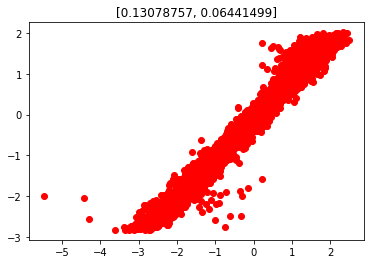

In [212]:
plt.plot(yte, pte, 'ro')
plt.title([np.std(yte-pte), np.mean(yte-pte)])

[Text(0.5, 1.0, 'Residuals, scatter is 0.131'),
 Text(0.5, 0, 'log10(M_stellar)_true-log10(M_stellar)_predicted'),
 Text(0, 0.5, 'N')]

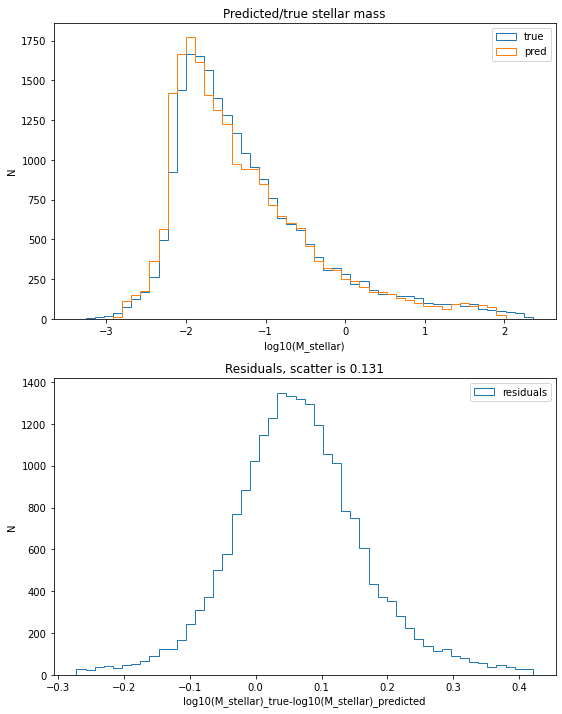

In [217]:
fig, ax= plt.subplots(2, figsize=(9,12))
bins=50
l=0.01
pred=pte
ax[0].hist(yte, bins=bins, range=(np.percentile(np.hstack([yte,pred]), [l,100-l])), label='true',  histtype='step')
ax[0].hist(pred, bins=bins, range=(np.percentile(np.hstack([yte,pred]), [l,100-l])), label='pred', histtype='step')
ax[1].hist((yte-pred), bins=bins,range=(np.percentile(yte-pred, [1,99])),  histtype='step', label='residuals');
ax[0].legend()
ax[1].legend()
ax[0].set(title='Predicted/true stellar mass', xlabel='log10(M_stellar)', ylabel='N')
ax[1].set(title=f'Residuals, scatter is {np.std(yte-pred):.3f}',xlabel='log10(M_stellar)_true-log10(M_stellar)_predicted', ylabel='N')

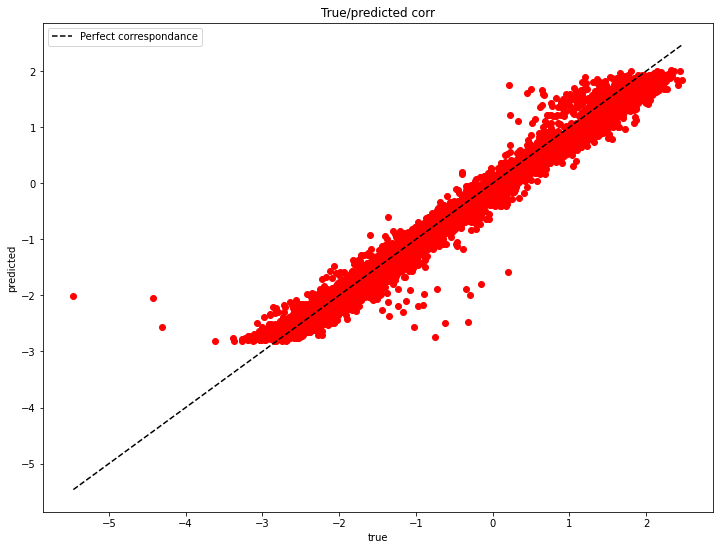

In [214]:
fig, ax =plt.subplots(figsize=(12,9))
ax.plot(yte,pred, 'ro')
ax.plot([min(yte),max(yte)],[min(yte),max(yte)], 'k--', label='Perfect correspondance')
ax.set(xlabel='true',ylabel='predicted', title='True/predicted corr')
ax.legend()

[Text(0.5, 0, 'true'),
 Text(0, 0.5, 'predicted'),
 Text(0.5, 1.0, 'True/predicted corr')]

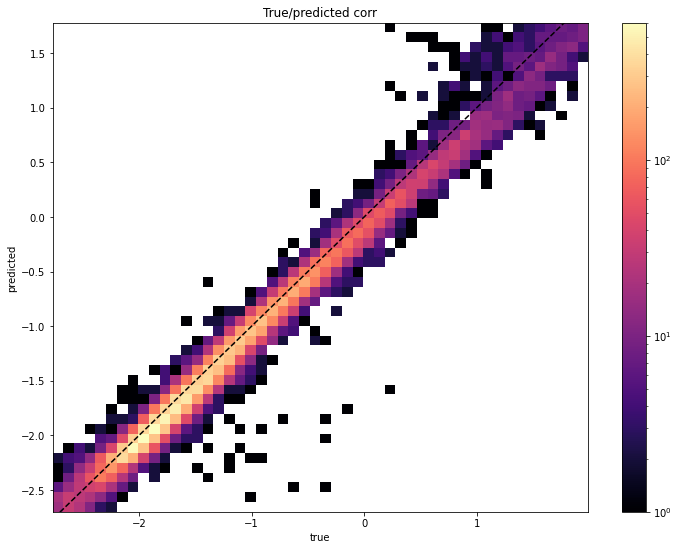

In [215]:
import matplotlib as mpl
l=0.5
fig, ax =plt.subplots(figsize=(12,9))
h = ax.hist2d(yte,pred, bins=50, range=[np.percentile(yte, [l,100-l]),np.percentile(pred, [l,100-l])],\
              norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)
fig.colorbar(h[3], ax=ax)
ax.plot([min(yte),max(yte)],[min(yte),max(yte)], 'k--', label='Perfect correspondance')
ax.set(xlabel='true',ylabel='predicted', title='True/predicted corr')
# ax.legend()

In [205]:
xs,ys=[], []
for d in data[int(len(data)*0.8):]:
    xs.append(d.x[0,3].numpy())
    ys.append(d.y.numpy())    

In [206]:
Mh=[]
for x in xes:
    Mh.append(x[0,3])
plt.plot(Mh, pred, 'o', markersize=1) 

NameError: name 'xes' is not defined

In [ ]:
plt.plot(x, y, 'o', markersize=1) 

In [ ]:
## remember to validate that test/val/train are actually comparable
## create toy problem (predict variance of all halo masses eg, verifying that in takes into account edges)
## same, predict average of the difference of post-merge halo and pre merger halos

## try different pools

In [ ]:
xte, yte, lte = [], [], []
for d in test_data:
    xte.append(d.x.numpy()[0,3])
    yte.append(d.y.numpy())    
    lte.append(np.log10(len(d.x.numpy()))   ) 
yte=np.vstack(yte)

In [ ]:
xtr, ytr, ltr = [], [], []
for d in train_data:
    xtr.append(d.x.numpy()[0,3])
    ytr.append(d.y.numpy())    
    ltr.append(np.log10(len(d.x.numpy()))   ) 
ytr=np.vstack(ytr)

In [ ]:
bins=20
fig, ax = plt.subplots(3, figsize=(12,12))
ax[0].hist(xtr, bins=bins, histtype='step', density=1, label='train')
ax[0].hist(xte, bins=bins, histtype='step', density=1, label='test')
ax[0].set(xlabel='Final halo mass')

ax[1].hist(ytr, bins=bins, histtype='step', density=1, label='train')
ax[1].hist(yte, bins=bins, histtype='step', density=1, label='test')
ax[1].set(xlabel='Stellar mass')

ax[2].hist(ltr, bins=bins, histtype='step', density=1, label='train')
ax[2].hist(lte, bins=bins, histtype='step', density=1, label='test');
ax[2].set(xlabel='log10(Tree length)')

for a in ax:
    a.set(yscale='log')
    a.legend()

In [51]:
import multiprocessing
multiprocessing.cpu_count()

28

In [52]:
os.cpu_count()

28